# Explore here

It's recommended to use this notebook for exploration purposes.

In [54]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [55]:
# PASO 1: pip install pandas requests lxml

In [56]:
# PASO 2:
resource_url = 'https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify'
response = requests.get(resource_url)
#todo ok si sale 200.
response.status_code

200

In [57]:
# PASO 3:
tablas = pd.read_html(resource_url)
print(f"Nº de tablas encontradas: {len(tablas)}")
df = tablas[0]
df

Nº de tablas encontradas: 27


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.823,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.343,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.891,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.874,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.862,1 April 2022,[6]
...,...,...,...,...,...,...
96,97,"""Stay with Me""",Sam Smith,2.287,14 April 2014,[98]
97,98,"""Someone Like You""",Adele,2.282,24 January 2011,[99]
98,99,"""Havana""",Camila Cabello and Young Thug,2.275,3 August 2017,[100]
99,100,"""Memories""",Maroon 5,2.254,20 September 2019,[101]


In [58]:
# PASO 4:
#quita filas sin valores.
df.dropna(inplace=True)
df = df.astype(str).apply(lambda x: x.str.replace("$", "").str.replace("B", "").str.strip())
df

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""linding Lights""",The Weeknd,4.823,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.343,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.891,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.874,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.862,1 April 2022,[6]
...,...,...,...,...,...,...
96,97,"""Stay with Me""",Sam Smith,2.287,14 April 2014,[98]
97,98,"""Someone Like You""",Adele,2.282,24 January 2011,[99]
98,99,"""Havana""",Camila Cabello and Young Thug,2.275,3 August 2017,[100]
99,100,"""Memories""",Maroon 5,2.254,20 September 2019,[101]


In [59]:
#PASO 5:
#print(df.columns)
# Conectar
conn = sqlite3.connect('spotify_songs.db')
cursor = conn.cursor()
# Crear tabla
cursor.execute('''
    CREATE TABLE IF NOT EXISTS canciones (
        titulo TEXT,
        artista TEXT,
        reproducciones REAL
    )
''')
# Copy DataFrame
df = df.copy()
# Renombra columnas
df.rename(columns={'Song': 'titulo', 'Artist(s)': 'artista', 'Streams (billions)': 'reproducciones'}, inplace=True)
# Columnas necesarias
df = df[['titulo', 'artista', 'reproducciones']]
# Convertir 'reproducciones' a número real
df['reproducciones'] = pd.to_numeric(df['reproducciones'], errors='coerce') * 1000000000
# Eliminar filas con valores no válidos en 'reproducciones'
df = df.dropna(subset=['reproducciones'])
# Insertar datos en la tabla
df.to_sql('canciones', conn, if_exists='append', index=False)
conn.commit()
conn.close()
print("Base de datos creada y datos insertados correctamente.")

Base de datos creada y datos insertados correctamente.


In [60]:
#PASO 6:
conn = sqlite3.connect('spotify_songs.db')
# Leer la tabla 'canciones' y visualizar los datos en un DataFrame
df = pd.read_sql("SELECT * FROM canciones", conn)
# Registros
print(df.head())
conn.close()

                titulo                   artista  reproducciones
0     "linding Lights"                The Weeknd    4.821000e+09
1       "Shape of You"                Ed Sheeran    4.341000e+09
2  "Someone You Loved"             Lewis Capaldi    3.889000e+09
3            "Starboy"  The Weeknd and Daft Punk    3.872000e+09
4          "As It Was"              Harry Styles    3.860000e+09


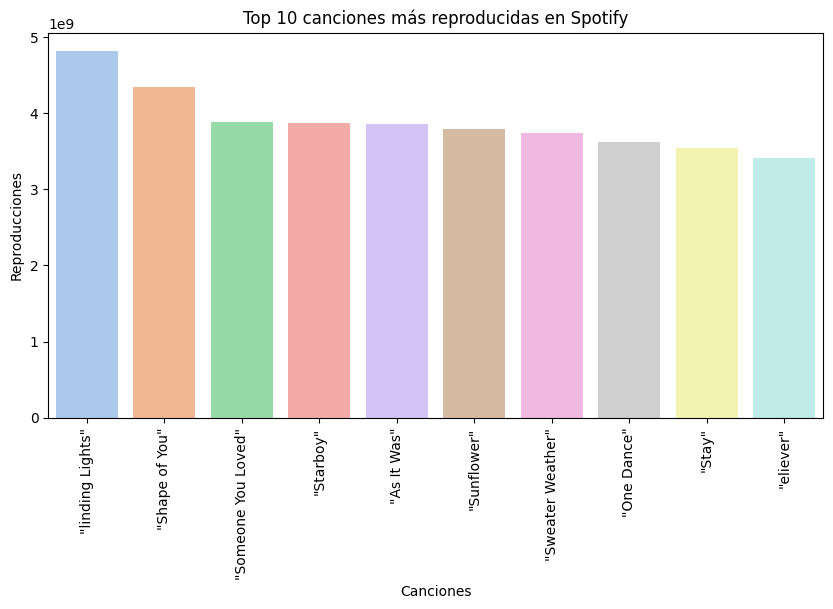

In [61]:
# Gráfico de barras
plt.figure(figsize=(10,5))
sns.barplot(x=df['titulo'][:10], y=df['reproducciones'][:10], hue=df['titulo'][:10], palette='pastel')
plt.xticks(rotation=90)
plt.xlabel('Canciones')
plt.ylabel('Reproducciones')
plt.title('Top 10 canciones más reproducidas en Spotify')
plt.show()

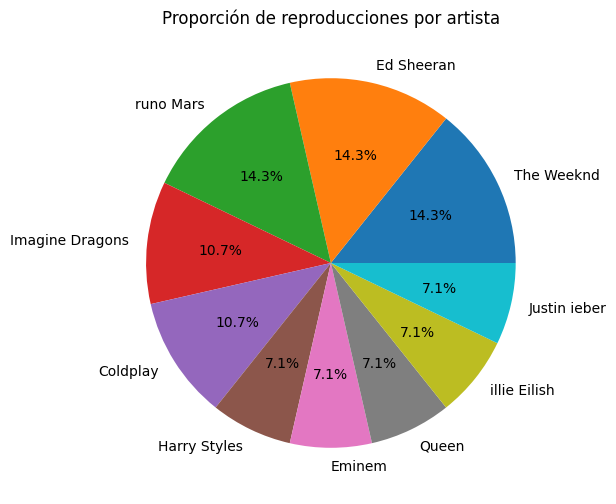

In [62]:
# Crear el gráfico de pastel
# Datos básicos
artistas = df['artista'].value_counts().nlargest(10)  # Top 10 artistas más reproducidos
plt.figure(figsize=(6,6))
plt.pie(artistas, labels=artistas.index, autopct='%1.1f%%')
plt.title('Proporción de reproducciones por artista')
plt.show()

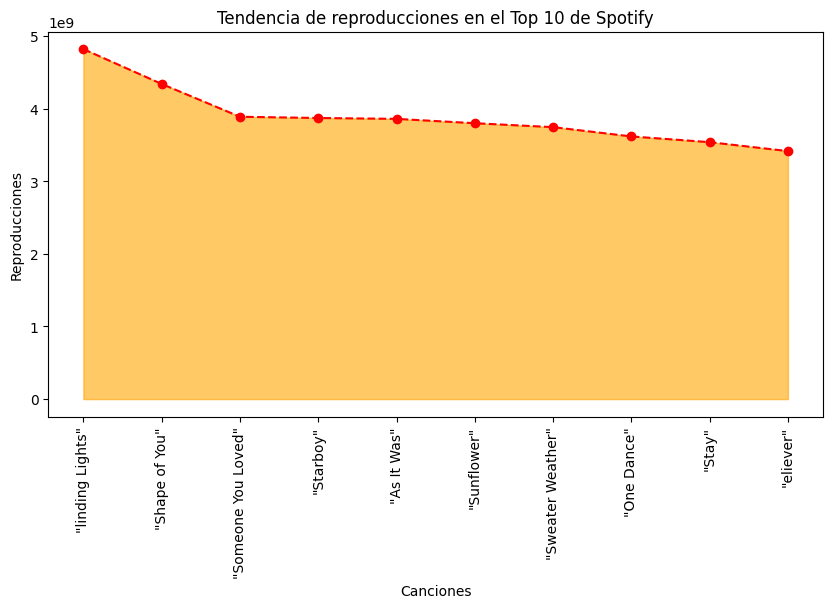

In [72]:
# Grfico de areas
plt.figure(figsize=(10,5))
plt.fill_between(df['titulo'][:10], df['reproducciones'][:10], color='orange', alpha=0.6)
plt.plot(df['titulo'][:10], df['reproducciones'][:10], marker='o', linestyle='--', color='red')
plt.xticks(rotation=90)
plt.xlabel('Canciones')
plt.ylabel('Reproducciones')
plt.title('Tendencia de reproducciones en el Top 10 de Spotify')
plt.show()